In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "../DATA/train.csv"
df = pd.read_csv(csv_path)

In [10]:
def evaluate_snr_catalog (df):
    # Required columns in this file: "SNR" (estimated) and "stack_snr"
    x_col = "SNR"
    y_col = "stack_snr"

    # Clean
    d = df[[x_col, y_col, "physical_filter", "trail_length", "stack_detection"]].copy()
    d = d[d["stack_detection"]==True]
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=[x_col, y_col])
    d = d[(d[x_col] > 0) & (d[y_col] > 0)]  # SNRs should be positive

    x = d[x_col].to_numpy()
    y = d[y_col].to_numpy()

    good_filter = (y<15) & (x>5)
    x = x[good_filter]
    y = y[good_filter]



    xmin, xmax = np.percentile(x, [0.5, 99.5])
    ymin, ymax = np.percentile(y, [0.5, 99.5])

    # Fit y = a*x + b
    a, b = np.polyfit(x, y, deg=1)

    plt.figure(figsize=(7, 6))
    hb = plt.hexbin(x, y, gridsize=70, mincnt=1)
    plt.colorbar(hb, label="count")

    xx = np.linspace(xmin, xmax, 200)
    plt.plot(xx, xx, linewidth=2, label="y=x")
    plt.plot(xx, a*xx + b, linewidth=2, label=f"fit: y={a:.3f}x + {b:.3f}")

    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel("Estimated SNR (SNR)")
    plt.ylabel("stack_snr")
    plt.title("stack_snr vs estimated SNR")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    res = y - x

    fig = plt.figure(figsize=(7, 5))
    plt.scatter(x, res, s=6, alpha=0.3)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel("Estimated SNR (SNR)")
    plt.ylabel("Residual (stack_snr - SNR)")
    plt.title("Residuals vs estimated SNR")
    plt.grid(True, alpha=0.3)
    plt.show()

    L = d["trail_length"].to_numpy()[good_filter]
    ratio = y / x

    plt.figure(figsize=(7, 5))
    plt.scatter(L, res, s=6, alpha=0.3)
    plt.axhline(0.0, linewidth=2)
    plt.xlabel("trail_length [px]")
    plt.ylabel("Residual (stack_snr - SNR)")
    plt.title("Ratio vs trail length")
    plt.ylim(np.percentile(res, 0.5), np.percentile(res, 99.5))
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(res, bins=80)
    plt.xlabel("Residual (stack_snr - SNR)")
    plt.ylabel("count")
    plt.title("Residual distribution")
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.hist(x, bins=80, histtype="step", label="estimated")
    plt.hist(y, bins=80, histtype="step", label="stack")
    plt.xlabel("SNR")
    plt.ylabel("count")
    plt.title("SNR distribution")
    plt.legend()
    plt.show()

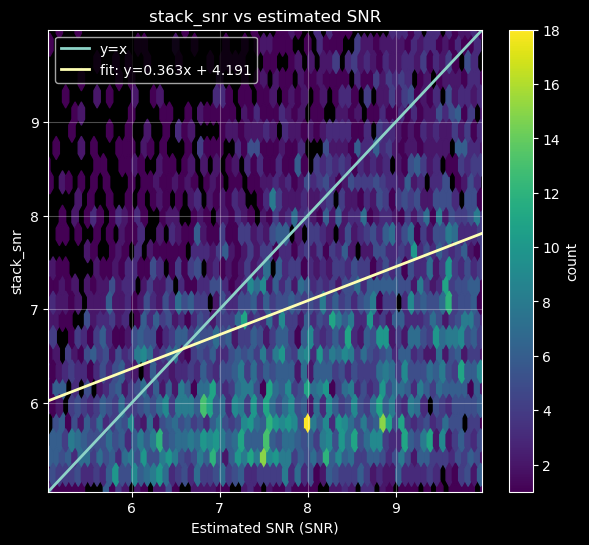

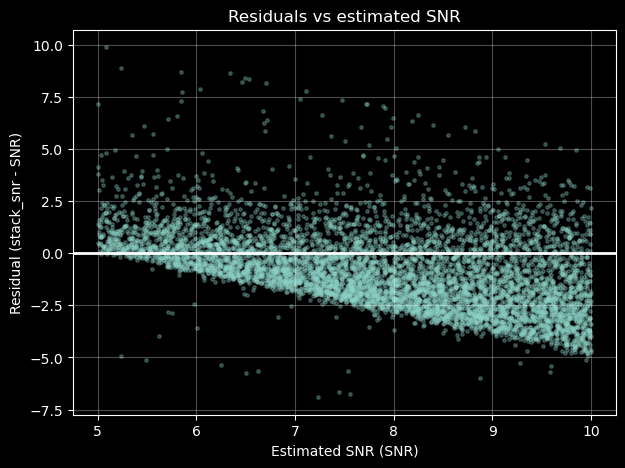

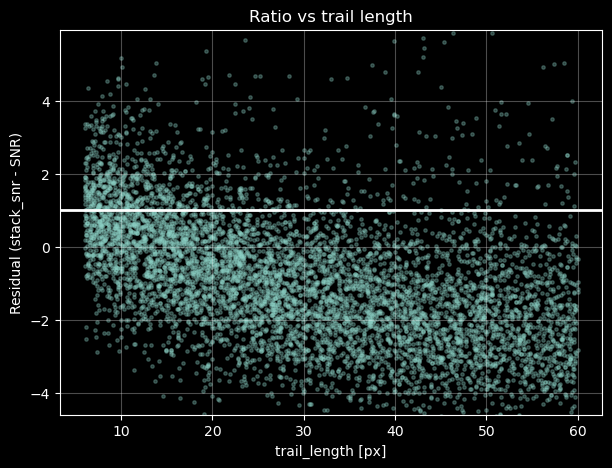

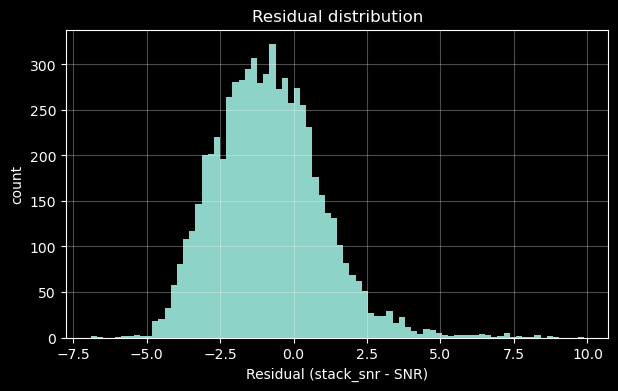

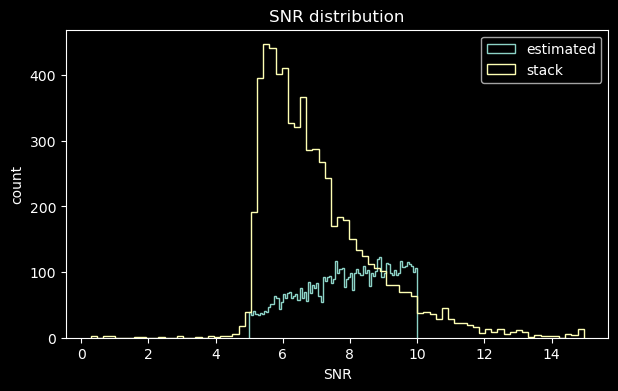

In [5]:
evaluate_snr_catalog(df)

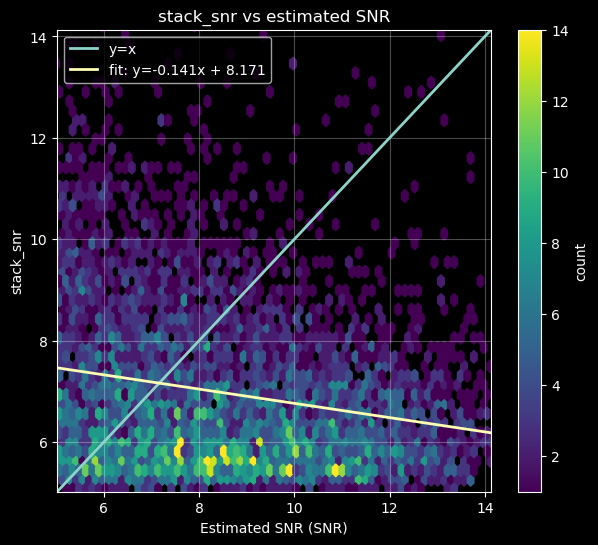

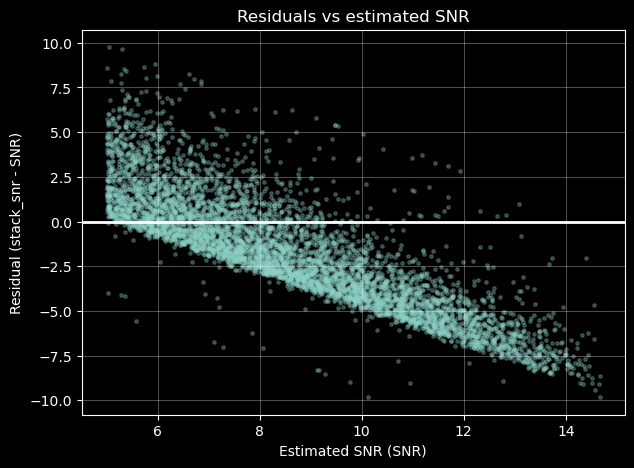

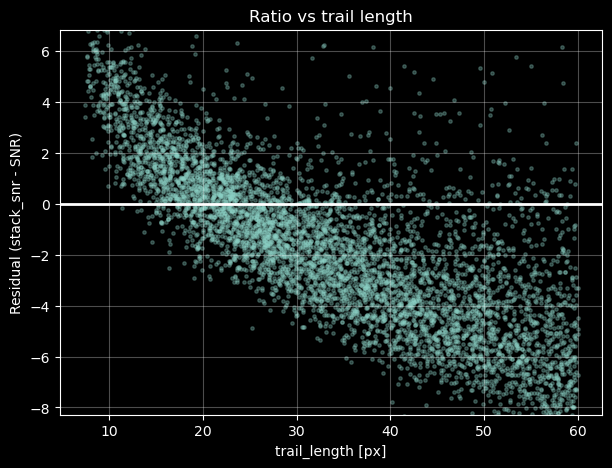

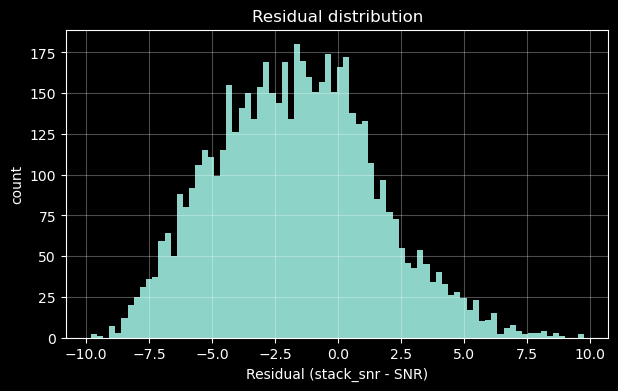

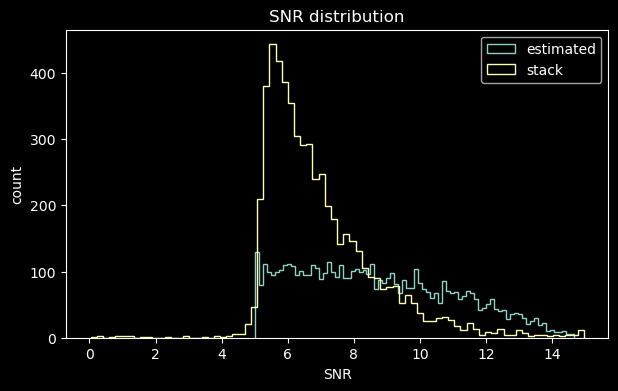

In [15]:
df_fixed = pd.read_csv("../DATA/train.csv")
df_fixed["SNR"] = df_fixed["SNR"] * np.sqrt(df_fixed["trail_length"]/ 27.57)
evaluate_snr_catalog(df_fixed)

In [18]:
W_psf = df["trail_length"] * (df["SNR"] / df["stack_snr"])**2
W_psf.median(), W_psf.quantile([0.1, 0.9])

(np.float64(27.572657567911996),
 0.1     3.96533
 0.9    97.43217
 dtype: float64)

In [21]:
df["W_psf_est"] = df["trail_length"] * (df["SNR"] / df["stack_snr"])**2
print (df.groupby(pd.cut(df["trail_length"], [0,10,20,40,80,200]))["W_psf_est"].median())

trail_length
(0, 10]       6.043560
(10, 20]     12.927703
(20, 40]     35.923929
(40, 80]     74.717141
(80, 200]          NaN
Name: W_psf_est, dtype: float64


/tmp/ipykernel_166534/4075410804.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print (df.groupby(pd.cut(df["trail_length"], [0,10,20,40,80,200]))["W_psf_est"].median())
